# Classification of Moving Clusters

In [ ]:
%matplotlib widget
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
import scipy.ndimage as img
import scipy.signal as signal 
import scipy.stats as stat
from alphashape import alphashape
import matplotlib.patches as patch
from functools import partial
from astropy.stats import kuiper
from shapely.geometry import Polygon

In [ ]:
import sys
import os
notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, os.pardir))
sys.path.append(parent_dir)
from Functions.Detection_functions import MCDA, circular_mask, preprocessing
from Functions.moving_cluster_class import Moving_Cluster

## Introduction

The purpose of this notebook is to implement a classifier of moving clusters between stationary pulses, target waves, planar waves and complex waves. To do so, two tests are deigned to assess if a given moving cluster is spreading or not, and if it is static or not. Then, two speeds are calculated, the radial speed if the pattern is expanding, and the translational speed if the pattern is moving. Finally, the isotropy of the global movement is tested to track preferential direction of propagation.

$$
\begin{array}{|c|c|c|}
\hline
\textbf{} & \textbf{Static} & \textbf{Moving} \\
\hline
\textbf{Stable} & \text{Stationary pulse} & \text{Planar wave} \\
\hline
\textbf{Spreading} & \text{Target wave} & \text{Complex wave} \\
\hline
\end{array}
$$

Choose a dataset

In [ ]:
condition='awake' #between anesthesia and awake
session='evoked' #between evokedU, evokedD and spontaneous

Write your data directory

In [ ]:
original_data_directory=r'/media/mathis/Data/Mathis/Original Data/'

Data loading

In [ ]:
if condition=='awake':
    fs = 100 #Hz
    pixel_spacing = 0.0566 #mm
    if session=='evoked':
        bks_evoked_path = original_data_directory+'gaussian_pos4_ziggy_210908.npy'
        Data = np.load(bks_evoked_path)
    elif session=='spontaneous':
        bks_blank_path = original_data_directory+'blank_ziggy_210908.npy'
        Data = np.load(bks_blank_path)
    mean = np.nanmean(Data)
    nan_loc = np.isnan(Data)
    Data[nan_loc] = mean
    N_trials, Nt, Nx, Ny = Data.shape
    mask = circular_mask((Nx,Ny), center=(220,190), radius=180) #160 should be more relevant

if condition=='anesthesia':
    fs=110 #Hz
    pixel_spacing = 0.0575 #mm
    if session=='evokedD':
        anesth_evokedD_path = original_data_directory+'signal_240306_gaussianD.mat'
        file_anesth_evokedD = h5py.File(anesth_evokedD_path)['signal']
        Data = np.array(file_anesth_evokedD)
    elif session=='evokedU':
        anesth_evokedU_path = original_data_directory+'signal_240306_gaussianU.mat'
        file_anesth_evokedU = h5py.File(anesth_evokedU_path)['signal']
        Data = np.array(file_anesth_evokedU)
    elif session=='spontaneous':
        anesth_blank_path = original_data_directory+'signal_240306_blank.mat' #change it to adapt to your directories
        file_anesth_blank = h5py.File(anesth_blank_path)['signal']
        Data = np.array(file_anesth_blank)
    N_trials, Nt, Nx, Ny = Data.shape
    mask = circular_mask((Nx,Ny), center=(125,140), radius=130) #155 should be more relevant

Choose a trial

In [545]:
trial_number=8
test_trial=Data[trial_number]
preprocessed_trial = preprocessing(trial=test_trial, border_mask=mask, fs=fs, fc=30, threshold=99)

Define parameters for Moving Clusters Detection Algorithm (MCDA)

In [546]:
eps=20
MinPts=32
theta=.40

Run MCDA

In [547]:
moving_clusters = MCDA(Trial=preprocessed_trial, epsilon=eps, min_pts=MinPts, Theta=theta)
print(f'{len(moving_clusters)} MC detected')

frame #0
frame #1
frame #2
frame #3
frame #4
frame #5
frame #6
frame #7
frame #8
frame #9
frame #10
frame #11
frame #12
frame #13
frame #14
frame #15
frame #16
frame #17
frame #18
frame #19
frame #20
frame #21
frame #22
frame #23
frame #24
frame #25
frame #26
frame #27
frame #28
frame #29
frame #30
frame #31
frame #32
frame #33
frame #34
frame #35
frame #36
frame #37
frame #38
frame #39
frame #40
frame #41
frame #42
frame #43
frame #44
frame #45
frame #46
frame #47
frame #48
frame #49
frame #50
frame #51
frame #52
frame #53
frame #54
frame #55
frame #56
frame #57
frame #58
frame #59
1 MC detected


Look at the detected Moving Clusters (MC)

In [548]:
for mc in moving_clusters:
    print(mc['trace'])

[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]


Choose a MC for further classification

In [549]:
mc_ind=0

## 1: Points of a detected moving cluster and lists of coordinates (X,Y,T)

In [550]:
pts=moving_clusters[mc_ind]['points']
pts_stack = np.concatenate(pts)
T=[time for index,time in enumerate(moving_clusters[mc_ind]['trace']) for _ in range(len(pts[index]))]
X,Y = pts_stack[:, 0], pts_stack[:, 1]

Visualisation of the moving cluster

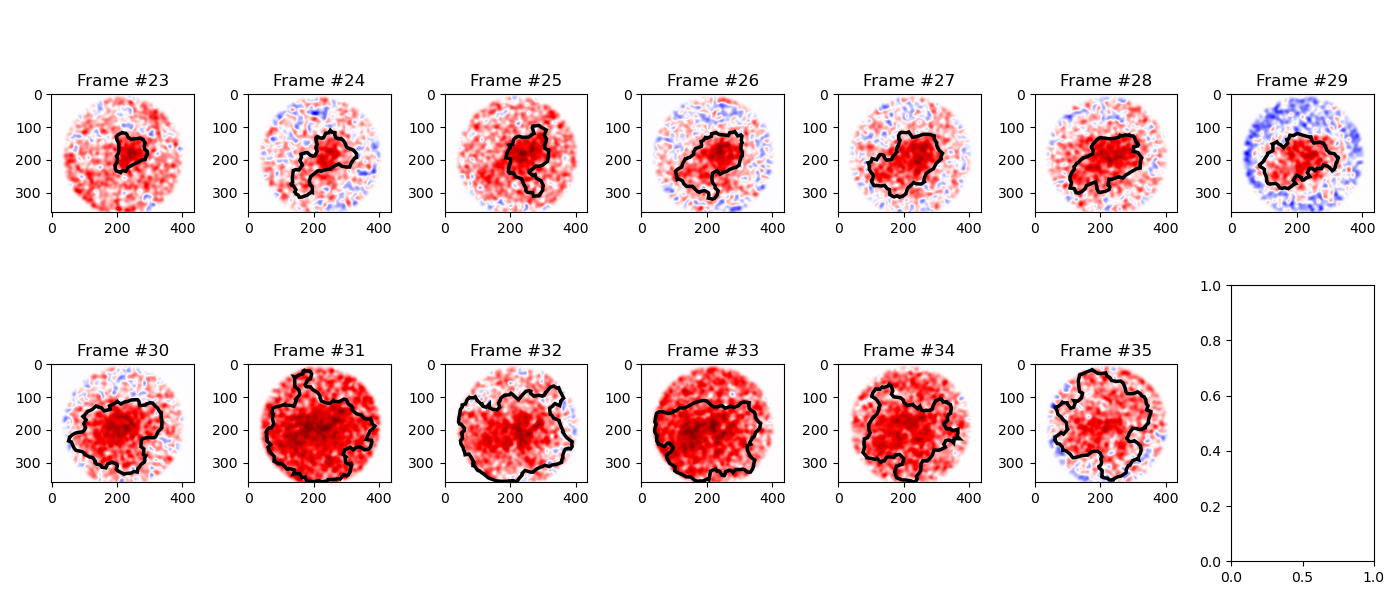

In [552]:
ncol=7
nrow=(len(pts)+len(pts)%2)//ncol

Norm = colors.Normalize(vmax=.5, vmin=-.5)
fig, axs = plt.subplots(nrow,ncol, figsize=(14,6), tight_layout=True)
for index,frame_number in enumerate(moving_clusters[mc_ind]['trace']):
    axs[index//ncol, index%ncol].set_title(f'Frame #{frame_number}')
    axs[index//ncol, index%ncol].imshow(img.gaussian_filter(test_trial[frame_number]*mask, sigma=5, mode='constant'), cmap='seismic', norm=Norm)
    x, y = moving_clusters[mc_ind]['alpha shapes'][index].exterior.xy
    mpl_poly = patch.Polygon(list(zip(y,x)), closed=True, edgecolor='k', facecolor='none', linewidth=2.5)
    axs[index//ncol, index%ncol].add_patch(mpl_poly)

## 2: Translation test

### 2.A: Linear correlation between spatial coordinates and time?

In [553]:
stat.pearsonr(T,X)

PearsonRResult(statistic=0.0031686178130985107, pvalue=0.7104713413736674)

In [554]:
stat.pearsonr(T,Y)

PearsonRResult(statistic=-0.08477570294970571, pvalue=2.524697416433428e-23)

In [555]:
stat.pearsonr(X,Y)

PearsonRResult(statistic=-0.09036903818644032, pvalue=2.707001046559429e-26)

Draw the linear regression

In [556]:
resx = stat.linregress(T,X)
resx

LinregressResult(slope=0.06142607377299642, intercept=206.18167732360268, rvalue=0.0031686178130985163, pvalue=0.7104713413736697, stderr=0.16546598165054913, intercept_stderr=5.117631769116415)

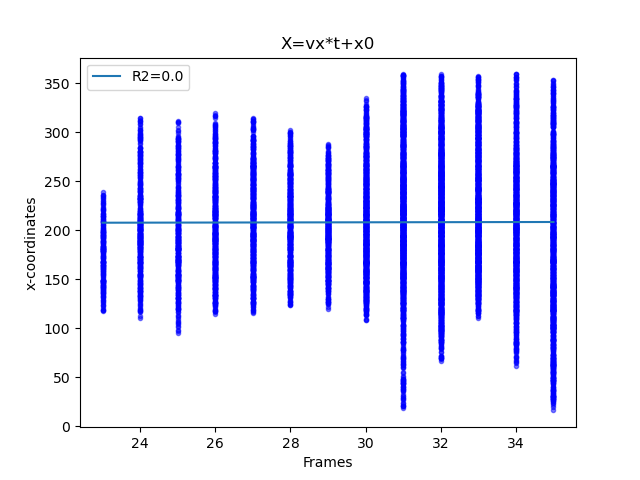

In [557]:
plt.figure()
plt.title('X=vx*t+x0')
plt.plot(T,X,'b.', alpha=.5)
plt.plot(T, [resx.intercept+resx.slope*time for time in T], label=f'R2={np.round(resx.rvalue**2,4)}')
plt.xlabel('Frames')
plt.ylabel('x-coordinates')
plt.legend()

In [558]:
resy = stat.linregress(T,Y)
resy

LinregressResult(slope=-1.847935023304155, intercept=267.9909869960934, rvalue=-0.08477570294970573, pvalue=2.5246974164328317e-23, stderr=0.18538604735114345, intercept_stderr=5.733731586464638)

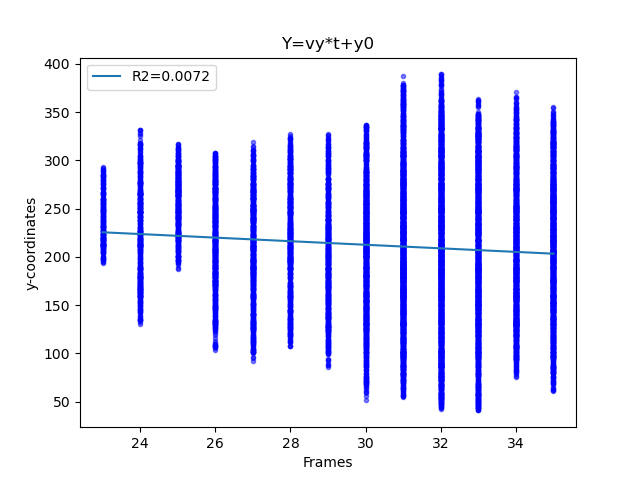

In [559]:
plt.figure()
plt.title('Y=vy*t+y0')
plt.plot(T,Y,'b.', alpha=.5)
plt.plot(T, [resy.intercept+resy.slope*time for time in T], label=f'R2={np.round(resy.rvalue**2,4)}')
plt.xlabel('Frames')
plt.ylabel('y-coordinates')
plt.legend()

resulting speed and angle

In [560]:
np.linalg.norm((resx.slope, resy.slope))*pixel_spacing/1000*fs

0.010465089005366576

In [561]:
np.arctan2(resy.slope,resx.slope)

-1.537568175217156

### 2.B: Centroids exceeding a minimal distance?

In [562]:
Centers=np.array([np.mean(clust_pts,axis=0) for clust_pts in moving_clusters[mc_ind]['points']])

In [563]:
Centers

array([[175.62173913, 238.26521739],
       [204.82857143, 223.38367347],
       [196.29032258, 256.2       ],
       [204.85866261, 215.52279635],
       [211.77466667, 208.52      ],
       [209.29191617, 221.19461078],
       [201.88432268, 200.68340944],
       [210.20134228, 203.62332215],
       [215.26129363, 208.76899384],
       [215.62155745, 207.29724596],
       [224.31268437, 204.89616519],
       [206.0748503 , 209.68562874],
       [181.85518591, 211.28832355]])

In [564]:
minimal_dist=10

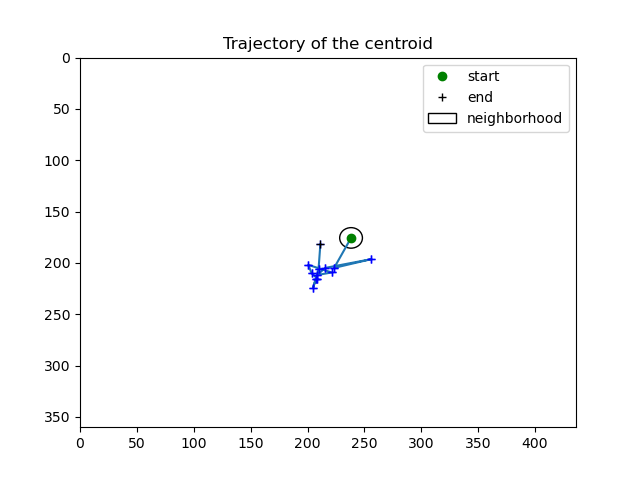

In [565]:
fig, ax = plt.subplots()
ax.set_title('Trajectory of the centroid')
ax.plot(Centers[:,1], Centers[:,0])
ax.plot(Centers[:,1], Centers[:,0], 'b+')
ax.plot(Centers[1:-1,1], Centers[1:-1,0], 'b+')
ax.plot(Centers[0,1], Centers[0,0], 'go', label='start')
ax.plot(Centers[-1,1], Centers[-1,0], 'k+', label='end')
circ = patch.Circle(Centers[0][::-1], minimal_dist,fill=False, label='neighborhood')
ax.add_patch(circ)
ax.set_xlim(0,Ny)
ax.set_ylim(0,Nx)
ax.invert_yaxis()
ax.legend()

### 2.C: Directional Persistance parameter

In [566]:
# Compute instantaneous velocities
velocities = np.diff(Centers, axis=0)

# Compute the dot products and norms
dot_products = np.einsum('ij,ij->i', velocities[:-1], velocities[1:])
norms = np.linalg.norm(velocities[:-1], axis=1) * np.linalg.norm(velocities[1:], axis=1)

# Compute directional persistence
directional_persistence = np.mean(dot_products / norms)

print(f"Directional Persistence: {directional_persistence}")

# Interpretation
if directional_persistence > 0.5:
    print("The cluster exhibits strong directional movement.")
elif directional_persistence < 0:
    print("The cluster exhibits anti-persistent movement.")
else:
    print("The cluster exhibits random or weak directional movement.")

Directional Persistence: -0.2094250657565394
The cluster exhibits anti-persistent movement.


In [567]:
pts=moving_clusters[mc_ind]['points']

In [568]:
def ttest(pts, MinDist, significance_level):
    none_list = np.full(len(pts),np.nan)
    centroids = ent=[np.mean(points, axis=0) for points in pts]
    source=centroids[0]
    velocities = np.diff(centroids, axis=0)
    dot_products = np.einsum('ij,ij->i', velocities[:-1], velocities[1:])
    norms = np.linalg.norm(velocities, axis=1)
    norms_prod = norms[:-1]*norms[1:]
    directional_persistence = np.mean(dot_products / norms_prod)
    test_persistence = directional_persistence>0.5
    centroids_from_source = np.linalg.norm(centroids - source, axis=1)
    test_mindist = np.max(centroids_from_source)>MinDist
    inter_test = test_persistence and test_mindist
    return (inter_test, np.append(norms, np.nan) if inter_test else none_list)

In [569]:
pt = np.array([[0,0],[1,0],[3,0]])

In [570]:
np.linalg.norm(pt, axis=1)

array([0., 1., 3.])

In [571]:
ttest(pts,1,.9)

(False,
 array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]))

In [572]:
from scipy.signal import fftconvolve

def compute_sample_mean_pdf(N, pdf, x_range):
    # Generate the pdf of the original distribution
    x = np.linspace(x_range[0], x_range[1], 100000)
    pdf_x = [pdf(y) for y in x]
    
    # Compute the convolution of the pdf with itself N times
    pdf_sum = pdf_x
    for _ in range(N - 1):
        pdf_sum = fftconvolve(pdf_sum, pdf_x, mode='same')
        pdf_sum /= np.trapz(pdf_sum, x)  # Normalize the pdf after convolution
    
    # Scale the pdf to get the pdf of the sample mean
    pdf_sample_mean = N * pdf_sum
    scaled_x = x / N

    return scaled_x, pdf_sample_mean

def plot_pdf(x, pdf, title):
    plt.figure()
    plt.plot(x, pdf, label='Sample Mean PDF')
    plt.xlabel('x')
    plt.ylabel('Density')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

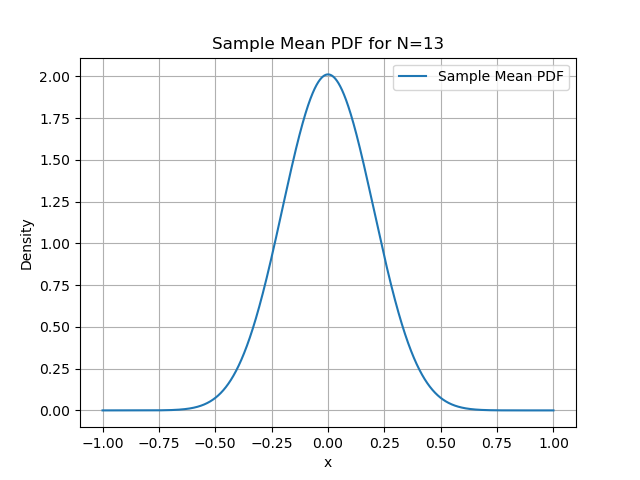

In [596]:
N = len(pts)
x_range = (-N, N)  # Adjust the range as necessary

def PDF(y):
    # Probability density function of X = cos(Theta)
    if abs(y)<1:
        return 1/(np.pi*np.sqrt(1 - y**2))
    else:
        return 0
scaled_x, pdf_sample_mean = compute_sample_mean_pdf(N, PDF, x_range)
plot_pdf(scaled_x, pdf_sample_mean, f'Sample Mean PDF for N={N}')


In [574]:
dx = scaled_x[1]-scaled_x[0]

In [575]:
np.sum(pdf_sample_mean*dx)

1.0000040473940908

In [597]:
DPP=directional_persistence

In [598]:
argu=np.argmin((scaled_x-DPP)**2)

In [599]:
scaled_x[argu]

-0.20943209432094329

In [602]:
pv=np.sum(pdf_sample_mean[argu:]*dx)

In [603]:
print(f'p-value={pv}')

p-value=0.8559143446281654


### Conclusion

In [580]:
def translation_test(moving_cluster,minimal_distance, significance_level=0.01):
    """
    Test if there at least one coordinate that is correlated with time according to a t-test
    ----
    Arguments:
        moving_cluster = dict that contains to key 'points' a list of numpy arrays with the coordinates of clusters points at each moment the cluster is defined
        significance_level = threshold above which null hypothesis (stationnary pulse in the corresponding axis) is rejected 
    ----
    Returns:
        the wave speed vector coordinates (vx, vy) if the test is passed, otherwise None
        (Do not forget to convert units in m/s!)
    """
    
    T = np.array([ time for index,time in enumerate(moving_cluster['trace']) for _ in range(len(moving_cluster['points'][index]))])
    pts_stack = np.concatenate(moving_cluster['points'])
    X,Y = pts_stack[:, 0], pts_stack[:, 1]
    centroids=[np.mean(moving_cluster['points'][0],axis=0), np.mean(moving_cluster['points'][-1],axis=0)]
    tot_dist=np.linalg.norm(np.diff(centroids, axis=1))
    res_x, res_y = stat.pearsonr(T,X).pvalue, stat.pearsonr(T,Y).pvalue
    return tot_dist>minimal_distance and (res_x<significance_level or res_y<significance_level)

In [581]:
translation_test(moving_clusters[mc_ind],5)

True

In [582]:
np.mean(moving_clusters[mc_ind]['points'][0],axis=0)

array([175.62173913, 238.26521739])

## 3: Expansion test

This test aims to assess if the pattern is speading or not. To do so, each is point is analysed in its own frame of reference, i.e. with its centroid as origin. Then, the distance from the center at each moment ("radius" $ \rho $) is calculated. The test is passed if $ \rho $ is increasing with time. The test checks also if the surface of the pattern is increasing to ensure a more robust result. 

### 3.A: Increasing radius?

In [583]:
pts_dist_to_centroid=[]
for clust in pts:
    center=np.mean(clust, axis=0) ##centroid location at each moment
    dist=np.linalg.norm(clust-center,axis=1) ## radius calculation
    pts_dist_to_centroid.append(dist)
Rho=np.concatenate(pts_dist_to_centroid)

In [584]:
res_rho = stat.linregress(T,Rho,alternative='greater')
print(f'p-value={res_rho.pvalue}')
if res_rho.pvalue<.01:
    print('Test 3A is passed')

p-value=0.0
Test 3A is passed


Linear regression of the radius

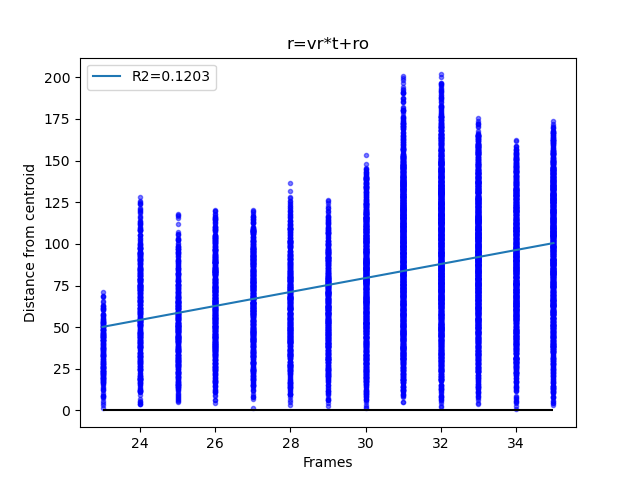

In [585]:
plt.figure()
plt.title('r=vr*t+ro')
plt.plot(T,Rho,'b.', alpha=.5)
plt.plot(T, [res_rho.intercept+res_rho.slope*time for time in T], label=f'R2={np.round(res_rho.rvalue**2,4)}')
plt.xlabel('Frames')
plt.ylabel('Distance from centroid')
plt.hlines(0,T[0],T[-1],'k')
plt.legend()

### 3.B: Increasing pattern surface?

In [586]:
surfaces=[pixel_spacing**2*shape.area for shape in moving_clusters[mc_ind]['alpha shapes']]

In [587]:
res_surf=stat.spearmanr(moving_clusters[mc_ind]['trace'], surfaces, alternative='greater')
print(f'p-value={res_surf.pvalue}')
if res_surf.pvalue<.01:
    print('Test 3B is passed')
else:
    print('Test 3B not passed')


p-value=2.9528726085955062e-05
Test 3B is passed


### 3.C: Conclusion

In [588]:
def expansion_test(moving_cluster, significance_level=.01):
    pts_dist_to_centroid=[]
    clust_surf=[]
    time_labels=[]
    for clust_pts,clust_shape,time in zip(moving_cluster['points'],moving_cluster['alpha shapes'], moving_cluster['trace']):
        center=np.mean(clust_pts, axis=0) 
        dist=np.linalg.norm(clust_pts-center,axis=1) 
        pts_dist_to_centroid.append(dist)
        clust_surf.append(clust_shape.area)
        time_labels+=[time for _ in range(len(clust_pts))]
    rho=np.concatenate(pts_dist_to_centroid)
    rho_regress = stat.pearsonr(time_labels,rho,alternative='greater').pvalue
    surf_regress = stat.pearsonr(moving_cluster['trace'], clust_surf, alternative='greater').pvalue
    print((rho_regress,surf_regress))
    return surf_regress<significance_level and rho_regress<significance_level

In [589]:
expansion_test(moving_clusters[mc_ind])

(0.0, 3.541870919746831e-05)


True

## 4: Test the isotropy of the movement

In [590]:
Source=np.mean(pts[0], axis=0)
Source

array([175.62173913, 238.26521739])

In [591]:
pts_angle_from_source=[]
for clust in pts:
    clust_from_source=clust-Source
    angle=np.arctan2(clust_from_source[:,0],clust_from_source[:,1])
    pts_angle_from_source.append(angle)
Angles=np.concatenate(pts_angle_from_source)

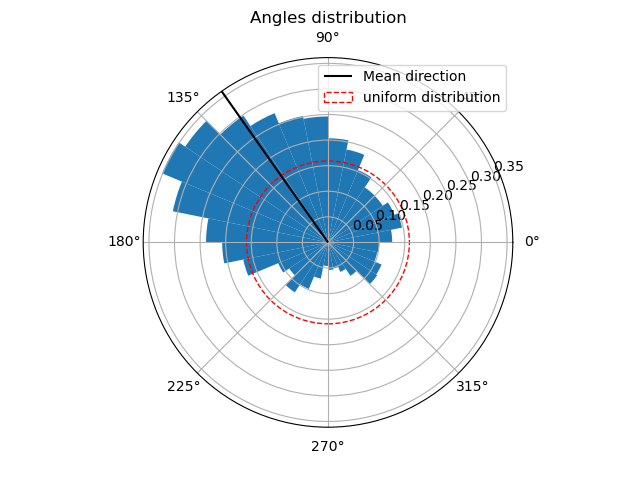

In [592]:
fig, ax1 = plt.subplots(subplot_kw={'projection': 'polar'})
ax1.set_title('Angles distribution')
histo = ax1.hist(Angles, bins=32, density=True)
ax1.vlines(stat.circmean(Angles),0,max(histo[0])+.01, colors='k',label='Mean direction')
uniform=patch.Circle((0,0),1/(2*np.pi), color='r',linestyle='dashed',fill=False, label='uniform distribution',transform=ax1.transData._b)
ax1.add_patch(uniform)
ax1.set_ylim(0, max(histo[0])+.01)
plt.legend()
plt.show()

### Test uniformity of the circular distribution

In [593]:
# Sample data: angles in radians
data = Angles#np.random.uniform(0, 2*np.pi, 100)

# Compute mean resultant length
n = len(data)
R = np.sqrt((np.sum(np.cos(data))**2 + np.sum(np.sin(data))**2) / n**2)

# Compute Rayleigh test statistic
Z = n * R**2

# Critical value for the Rayleigh test (for large n, use approximate critical values)
p_value = np.exp(-Z)

print("Rayleigh Test Statistic:", Z)
print("p-value:", p_value)

if p_value < 0.01:
    print("Reject the null hypothesis: the distribution is not uniform.")
else:
    print("Fail to reject the null hypothesis: the distribution may be uniform.")

Rayleigh Test Statistic: 1583.0435589298352
p-value: 0.0
Reject the null hypothesis: the distribution is not uniform.


In [594]:
kuiper_test=kuiper(data=Angles, cdf=partial(stat.uniform.cdf, loc=-np.pi, scale=2*np.pi))
print("Kuiper Test Statistic:", kuiper_test[0])
print("fpp:", kuiper_test[1])

if kuiper_test[1] < 0.01:
    print("Reject the null hypothesis: the distribution is not uniform.")
else:
    print("Fail to reject the null hypothesis: the distribution may be uniform.")

Kuiper Test Statistic: 0.2288979121066501
fpp: 0.0
Reject the null hypothesis: the distribution is not uniform.


In [595]:
kuiper_test

(0.2288979121066501, 0.0)